In [1]:
# import escher
from importlib import resources
import ipywidgets as widgets
import jax
import jax.numpy as jnp
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# import panel as pn
import scipy

import mosmo.preso.escher.pw as pw_files
from mosmo.knowledge import kb
from mosmo.knowledge.thermo import Thermodynamics
from mosmo.model import DbXref, Molecule, Reaction, ReactionNetwork
from mosmo.preso.escher.escher_model import escher_model
from mosmo.calc import fba_gd
from mosmo.calc.convenience_kinetics import ConvenienceKinetics, ReactionKinetics, PackedNetworkKinetics

jax.config.update('jax_enable_x64', True)
jnp.zeros(1)  # triggers the jax GPU warning

KB = kb.configure_kb()
thermo = Thermodynamics(p_h=7.3, p_mg=1.5, ionic_strength=0.25, temperature=298.15)
RT = 8.314463e-3 * 298.15  # kJ / mol
FARADAY = 96.485332  # kC / mol

# escher_options = {
#     'menu': 'zoom',
#     'enable_editing': False,
#     'never_ask_before_quit': True,
#     'reaction_styles': ['color', 'size', 'abs'],
#     'reaction_scale': [
#         {'type': 'value', 'value': 0, 'color': '#eeeeee', 'size': 3},
#         {'type': 'value', 'value': 5, 'color': '#1f77b4', 'size': 20},
#     ],
# }

## PMF

In [2]:
water = KB("h2o")
proton = KB("h+")
proton_p = Molecule(id='h+.p', name="proton (periplasm)", shorthand="H+(p)", charge=+1)
electron = Molecule(id='e-', name='electron', shorthand='e-', charge=-1, mass=0.000548579903, xrefs=(DbXref("CHEBI","10545"),))
ignore = set([proton, proton_p, electron, water])  # All ignored for kinetic purposes

d_psi = -150  # mV
ph_p = 6.7
dg_p_psi = d_psi / 1000 * FARADAY  # mV * V/mV * (kJ/kC)/V * kC/mol = kJ/mol
dg_p_ph = -np.log(10) * RT * (thermo.cc.p_h.m - ph_p)
dg_p = dg_p_psi + dg_p_ph
thermo.set_formation_delta_g(proton_p, -dg_p)

print(f"At Δψ = {d_psi} mV and ΔpH = {thermo.cc.p_h.m - ph_p:.2f}:")
print(f"ΔGp = FΔψ + RT ln(H+[p]/H+[c]) = {dg_p_psi:.3f} + {dg_p_ph:.3f} = {dg_p:.3f}")

At Δψ = -150 mV and ΔpH = 0.60:
ΔGp = FΔψ + RT ln(H+[p]/H+[c]) = -14.473 + -3.425 = -17.898


## NAD(P)(H) Couple

In [4]:
# All Km in mM, all kcat in 1/s
reaction_kinetics = {}

nad = KB("nad.ox")
nadh = KB("nad.red")
nadp = KB("nadp.ox")
nadph = KB("nadp.red")

nad_reduction = Reaction("nad_red", name="NAD reduction", aka=["NAD half-cell"], stoichiometry={nad: -1, proton: -1, electron: -2, nadh: +1})
nadp_reduction = Reaction("nadp_red", name="NADP reduction", aka=["NADP half-cell"], stoichiometry={nadp: -1, proton: -1, electron: -2, nadph: +1})

udha = Reaction(
    id="UdhA", 
    name="Energy-independent transhydrogenase",
    stoichiometry={nadh: -1, nadp: -1, nad: +1, nadph: +1},
    catalyst=Molecule(id="UdhA"),
    xrefs=(DbXref("EC", "1.6.1.1"),
           DbXref("RHEA", "11692"),
           DbXref("KEGG", "R00112"),
           DbXref("METACYC", "PYRNUTRANSHYDROGEN-RXN"),
           DbXref("GO", "0008746")),
)
reaction_kinetics[udha] = ReactionKinetics.thermo_consistent(
    reaction=udha, delta_g=thermo.reaction_delta_g(udha), km={nad: 0.133, nadph: 0.068}, kcat_f=200, ki={nadph: 1.0})

pntab = Reaction(
    id="PntAB", 
    name="PMF-coupled transhydrogenase",
    stoichiometry={nadh: -1, nadp: -1, proton_p: -1, nad: +1, nadph: +1, proton: +1},
    catalyst=Molecule(id="PntAB"),
    xrefs=(DbXref("EC", "7.1.1.1"),
           DbXref("RHEA", "47992"),
           DbXref("METACYC", "TRANS-RXN0-277")),
)
reaction_kinetics[pntab] = ReactionKinetics.thermo_consistent(reaction=pntab, delta_g=thermo.reaction_delta_g(pntab), kv=1., ignore=ignore)

## NADH Dehydrogenase I

In [5]:
qone = KB("q.ox")
qol = KB("q.red")
q_reduction = Reaction("q_red", name="Ubiquinone Reduction", aka=["Ubiquinone half-cell"], stoichiometry={qone: -1, electron: -2, qol: +1})

ndh1 = Reaction(
    id="ndh1",
    name="NADH:ubiquinone oxidoreductase (H+ translocating)",
    stoichiometry={nadh: -1, qone: -1, proton: -5, nad: +1, qol: +1, proton_p: +4},
    catalyst=Molecule(id="NuoA-N"),
    xrefs=(DbXref("EC", "7.1.1.2"),
           DbXref("RHEA", "29091"),
           DbXref("KEGG", "R11945"),
           DbXref("METACYC", "NADH-DEHYDROG-A-RXN"),
           DbXref("GO", "0008137")),
    reversible=False,
)
reaction_kinetics[ndh1] = ReactionKinetics.thermo_consistent(
    reaction=ndh1, delta_g=thermo.reaction_delta_g(ndh1), km={nadh: 0.013, qone: 0.08}, kcat_f=26., ignore=ignore)

## Cytochrome bo3 and bd1 Oxidases
- $bo_3$ is low-affinity (and presumably high-turnover?), used in high O2
- _bd_-I is high-affinity, used in low oxygen
- But both use the same EC number, 7.1.13, which complicates using kinetic data from BRENDA.
- $K_M$ values have been reported with respect to QH2, but not with respect to O2. However, we do know that bdI is expressed under low-oxygen conditions, and is consistently referred to as high-affinity for oxygen. Try to reflect this in the kinetics. Unknown(?) how this translates to affinity for QH2.
- It is possible we will want to model the kinetics of ndh1, cytbo3, and cytbd1 in more mechanistic detail (e.g. as in https://www.sciencedirect.com/science/article/pii/S0005272811001587) rather than the random-order equilibrium binding assumptions of convenience kinetics. But today is not that day.

In [6]:
oxygen = Molecule(
    id="o2", name="oxygen", shorthand="O2",
    formula="O2", charge=0, mass=31.998,
    xrefs=(DbXref("CHEBI", "15379"), DbXref("KEGG", "C00007"))
)

# Some dispute on the stoichiometry of this? BiGG has both CYTBO3 and CYTBO3_4pp.
# But note that the core reaction 2 QH2 + O2 <=> 2 Q + 2 H2O has a ΔG of a whopping -286.1, more than enough to offset 8 pumped protons at 17.9 each.
cytbo3 = Reaction(
    id="cytbo3",
    name="Cytochrome bo3 Oxidase",
    stoichiometry={qol: -2, proton: -8, oxygen: -1, qone: +2, proton_p: +8, water: +2},  # some sources base this on 1/2 O2; we use 1 O2
    catalyst=Molecule(id="CyoABCDE"),
    xrefs=(DbXref("EC", "7.1.1.3"),
           DbXref("RHEA", "30251"),
           DbXref("KEGG", "R11335"),
           DbXref("METACYC", "RXN0-5268"),
           DbXref("GO", "0009486")),
    reversible=False,
)
reaction_kinetics[cytbo3] = ReactionKinetics.thermo_consistent(
    reaction=cytbo3, delta_g=thermo.reaction_delta_g(cytbo3), km={qol: 0.05, oxygen: 0.05}, kcat_f=300., ignore=ignore)  # unknown

cytbd1 = Reaction(
    id="cytbd1",
    name="Cytochrome bd1 Oxidase",
    stoichiometry={qol: -2, proton: -4, oxygen: -1, qone: +2, proton_p: +4, water: +2},  # some sources base this on 1/2 O2; we use 1 O2
    catalyst=Molecule(id="CydAB"),  # or CbdAB / CyxAB. But then, that should a third reaction, shouldn't it?
    xrefs=(DbXref("EC", "7.1.1.7"),
           DbXref("RHEA", "40527"),
           DbXref("KEGG", "R11325"),
           DbXref("METACYC", "RXN0-5266")),
    reversible=False,
)
# Numbers from Jünemann et al (1995) Biochemistry
reaction_kinetics[cytbd1] = ReactionKinetics.thermo_consistent(
    reaction=cytbd1, delta_g=thermo.reaction_delta_g(cytbd1), km={qol: 0.04, oxygen: 2e-3}, kcat_f=470., ignore=ignore)  # unknown


### Put in the KB (commented out)

In [7]:
# KB.put(KB.compounds, proton_p)
# KB.put(KB.compounds, electron)

# KB.put(KB.reactions, nad_reduction)
# KB.put(KB.reactions, nadp_reduction)
# KB.put(KB.reactions, q_reduction)
# KB.put(KB.reactions, udha)
# KB.put(KB.reactions, pntab)
# KB.put(KB.reactions, ndh1)
# KB.put(KB.reactions, cytbo3)
# KB.put(KB.reactions, cytbd1)

## Build the network and ODE system

Characteristics of the netork:
- Include NAD/NADP transhydrogenases. Eventual plan is to include an extensive reservoir/buffer of electrons.
- Concentrate on Q/QH2 (ubiquinone) as the intermediate carrier. Eventually extend to menaquinone and demethylmenaquinone.
- Concentrate on the 'mainline' ETC NADH -> O2.
- Include half-cell reduction (or oxidation) reactions for each carrier pool -- NAD+/NADH, NADP+/NADPH, and Q/QH2 -- as boundaries or connections to external metabolism, including glycolysis, PPP, TCA cycle (and specifically SDH). A point of interest is how the balance among these electron sources/sinks affects flow through the ETC.

In [8]:
network = ReactionNetwork([udha, pntab, ndh1, cytbo3, cytbd1, nad_reduction, nadp_reduction, q_reduction])
print(pd.DataFrame(network.s_matrix,
                   index=[mol.label for mol in network.reactants],
                   columns=[rxn.label for rxn in network.reactions],
                   dtype=int))

# escher.Builder(
#     **escher_options,
#     model_json=json.dumps(escher_model("electron_transport", network.reactions)),
#     map_json=resources.read_text(pw_files, 'electron_transport.json'),
#     reaction_data={rxn.label: 1 for rxn in network.reactions},
# )

       UdhA  PntAB  ndh1  cytbo3  cytbd1  nad_red  nadp_red  q_red
NADH     -1     -1    -1       0       0        1         0      0
NADP+    -1     -1     0       0       0        0        -1      0
NAD+      1      1     1       0       0       -1         0      0
NADPH     1      1     0       0       0        0         1      0
H+(p)     0     -1     4       8       4        0         0      0
H+        0      1    -5      -8      -4       -1        -1      0
Q         0      0    -1       2       2        0         0     -1
QH2       0      0     1      -2      -2        0         0      1
O2        0      0     0      -1      -1        0         0      0
H2O       0      0     0       2       2        0         0      0
e-        0      0     0       0       0       -2        -2     -2


## FBA, balancing electron flux via NAD, NADP, and Q pools

In [9]:
boundaries = [proton, proton_p, electron, oxygen, water]
fba = fba_gd.FbaGd(
    network, 
    intermediates=[reactant for reactant in network.reactants if reactant not in boundaries],
    objectives={'fluxes': fba_gd.VelocityObjective(network, {nad_reduction: 0, nadp_reduction: 0, q_reduction: 0})},
)

# diag = escher.Builder(
#     **escher_options,
#     height=400,
#     map_json=resources.read_text(pw_files, 'electron_transport.json'),
#     reaction_data={r.label: 0 for r in network.reactions},
# )

# slider_opts = {'min': -5, 'max': 5, 'step': 0.1, 'continuous_update': False, 'readout': True, 'readout_format': '.1f'}
# nadh_slider = widgets.FloatSlider(**slider_opts, description='NADH', value=0)
# nadph_slider = widgets.FloatSlider(**slider_opts, description='NADPH', value=0)
# qh2_slider = widgets.FloatSlider(**slider_opts, description='QH2', value=0)

# def update_fba(change):
#     fba.update_params({'fluxes': {nad_reduction: nadh_slider.value, nadp_reduction: nadph_slider.value, q_reduction: qh2_slider.value}})
#     soln = fba.solve()
#     diag.reaction_data = {r.label: v for r, v in zip(network.reactions, soln.velocities)}

# nadh_slider.observe(update_fba, names='value')
# nadph_slider.observe(update_fba, names='value')
# qh2_slider.observe(update_fba, names='value')
# dashboard = widgets.HBox(
#     [widgets.VBox([diag], layout = widgets.Layout(width='75%', height='100%')),
#      widgets.VBox([nadh_slider, nadph_slider, qh2_slider], layout = widgets.Layout(width='25%', height='100%'))],
#     layout = widgets.Layout(width='1200px', height='400px', border='1px solid green')
# )
# dashboard

Observations from FBA explorations
- Electrons pass into ETC only if nadp_red + nad_red > 0
- If nadp_red < 0, PMF drives transhydrogenase, but if nadp_red > 0, PntAB can drive PMF. Actually this has to depend on the enrgetics, but FBA ignores that
- (Infered) ndh1 + q_red = cytbo3 + cytbd1, but without additional constraints the distribution between the two cytochromes is variable
- There are actually a few paths; maybe elementary mode analysis would be useful

In [10]:
from mosmo.calc.elementary_modes import elementary_modes

def build_internal_system(network, bounds):
    """Returns S matrix with rows for internal (non-bounds) metabolites only."""
    intermediates = [met not in bounds for met in network.reactants]
    return network.s_matrix[intermediates].astype(int)

def mode_formula(network, mode):
    parts = []
    for reaction, coeff in zip(network.reactions, mode):
        if coeff == -1:
            parts.append('-')
        elif coeff < 0:
            parts.append(f'- {-coeff}')
        elif coeff == 1:
            if parts:
                parts.append('+')
        elif coeff > 0:
            if parts:
                parts.append(f'+ {coeff}')
            else:
                parts.append(f'{coeff}')
        
        if coeff:
            parts.append(reaction.label)
    
    return ' '.join(parts)

def show_modes(network, modes, rev):
    s_elementary = (network.s_matrix.astype(int) @ modes)
    net_reactions = []
    for i, (mode, reversible) in enumerate(zip(s_elementary.T, rev)):
        stoich = {}
        for met, count in zip(network.reactants, mode):
            if count != 0:
                stoich[met] = count

        net_reaction = Reaction(_id=f'mode{i}', name=f'Elementary Mode {i}', stoichiometry=stoich, reversible=reversible)
        net_reactions.append(net_reaction)

    w = f'{160 + modes.shape[1] * 8:d}px' if modes.shape[1] < 80 else '100%'
    mode_select = widgets.IntSlider(
        value=0,
        min=0,
        max=modes.shape[1] - 1,
        description='Mode',
        continuous_update=True,
        readout=True,
        layout={'width': w}
    )
    mode_fluxes = widgets.Text(description='flux ratios', layout={'width': '100%'})
    mode_net = widgets.Text(description='net reaction', layout={'width': '100%'})
    diag = escher.Builder(**escher_options, height=400, map_json=resources.read_text(pw_files, 'electron_transport.json'), reaction_data={})

    def show_mode(change):
        mode = mode_select.value
        mode_fluxes.value = mode_formula(network, modes.T[mode])
        mode_net.value = net_reactions[mode].formula
        diag.reaction_data = {r.label: v for r, v in zip(network.reactions, modes.T[mode])}

    mode_select.observe(show_mode, names='value')
    show_mode(None)

    return widgets.VBox([mode_select, mode_fluxes, mode_net, diag])

modes, rev = elementary_modes(build_internal_system(network, boundaries), (reaction.reversible for reaction in network.reactions))
# show_modes(network, modes, rev)

## Kinetics
### Concentrations, including Q and QH2

- https://www.sciencedirect.com/science/article/pii/S0005272897000340 Table 2 gives (aerobic) .36 ubiquinone, .22 demethylmenaquinone, and .02 menaquinone μmol / g DCW
- http://book.bionumbers.org/how-big-is-an-e-coli-cell-and-what-is-its-mass/ gives 430 fg DCW for one cell @ 40 min doubling time, standard for minimal + glucose. This translates to ~ 1.3 fL ~= 1.3 pg.
- Regardless of cell size, the expectation is that 1 g DCW ~ 3 g wet weight ~ 3 ml cell volume
- This gives us 3.6e-7 mol / 3e-3 l = 1.2e-4 M = **0.12 mM UQ, 0.07 mM DMK, 0.007 mM MK**
- Alternate path: 3.6e-7 mol/gDCW * 4.3e-13 gDCW/cell * 6e23 count/mol ~ 93000 count/cell ~ 0.093 mM.
  - Rough rule of thumb numbers aren't all consistent, but this is in the same range.
- Assuming this is actually the total of Q + QH2. We need to find an estimate of the steady-state redox charge of the Q pool

**Not explored yet**: these are concentrations as if quinones are solubilized within the full cellular volume (3d), when they in fact diffuse within the membrane (2d). Rationalization for now is that reported values e.g. for Km also use concentration. This may be another facet in which we need a more specialized model for these kinetics. OTOH if the bottom line is that these enzyme are more or less saturated wrt Q and QH2 then it's all moot anyway.

In [11]:
concs = {
    nad: 2.55,
    nadh: 8.36e-02,
    nadp: 2.08e-03,
    nadph: 1.21e-01,
    oxygen: 0.25,  # http://book.bionumbers.org/what-are-environmental-o2-and-co2-concentrations/
    proton: np.power(10, -7.3) * 1000,
    proton_p: np.power(10, -6.7) * 1000,
    qol: 0.04,
    qone: 0.06,
    water: 1.0,  # activity of the solvent, not concentration per se
}

# Enzyme concentrations taken from https://pubmed.ncbi.nlm.nih.gov/26641532/.
# Cell volume(s) from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3146540/
cell_volume = 3.0e-15
avogadro = 6.022e23
enzymes = {
    udha: 448 / avogadro / cell_volume,
    pntab: np.mean([1938, 2977]) / avogadro / cell_volume,
    ndh1: np.mean([934, 935, 393, 748, 305, 294, 437, 133, 229]) / avogadro / cell_volume,
    cytbo3: np.mean([2616, 957, 136]) / avogadro / cell_volume,
    cytbd1: np.mean([344, 43]) / avogadro / cell_volume,
}

equations = ConvenienceKinetics(network, reaction_kinetics, ignore=ignore)
state0 = network.reactants.pack(concs)
enz_state = network.reactions.pack(enzymes)

### Steady State

In [12]:
couples = [
    (nadp, nadph),
    (nad, nadh),
    (qone, qol),
]
couples_i = np.array([[network.reactants.index_of(couple[0]), network.reactants.index_of(couple[1])] for couple in couples])
couples_capacity = np.sum(state0[couples_i], axis=-1)
intermediates_i = np.array([i for i, reactant in enumerate(network.reactants) if reactant not in boundaries])

# x[i] = charge(couple[i])
def adjusted_state(state, x):
    reduced_form = x * couples_capacity
    return jnp.asarray(state).at[couples_i[:, 0]].set(couples_capacity - reduced_form).at[couples_i[:, 1]].set(reduced_form)

# include terms for 0 <= x <= 1
def ss_residual(x):
    dmdt = equations.dstate_dt(adjusted_state(state0, x), enz_state)
    return jnp.concatenate([jnp.maximum(0, -x) + jnp.maximum(0, x - 1), dmdt[intermediates_i]])


In [13]:
soln = scipy.optimize.least_squares(
    fun=jax.jit(ss_residual),
    x0=jnp.ones(3) * 0.5,
    jac=jax.jit(jax.jacfwd(ss_residual)),
)
soln.x

array([0.56353698, 0.05425494, 0.08265202])

Of course, without an external source of electrons, the steady state is depleted. Drive influx via nadp_red, nad_red, and q_red

In [14]:
%%time
drivers = [nadp_reduction, nad_reduction, q_reduction]
drivers_i = np.array([network.reactions.index_of(driver) for driver in drivers])
driver_mask = np.array([0., 1., 0.])
rate_range = np.linspace(-1e-4, 1e-4, 21)

def network_rates(state, enz_state, driver_rates):
    rates = equations.reaction_rates(state, enz_state)
    rates = rates.at[drivers_i].add(driver_rates)
    return rates

def residual(x, driver_rates):
    rates = network_rates(adjusted_state(state0, x), enz_state, driver_rates)
    dmdt = network.s_matrix @ rates
    return jnp.concatenate([jnp.maximum(0, -x) + jnp.maximum(0, x - 1), dmdt[intermediates_i]])

pool_charge = []
for rate in rate_range:
    soln = scipy.optimize.least_squares(
        fun=jax.jit(residual),
        jac=jax.jit(jax.jacfwd(residual)),
        x0 = jnp.ones(3) * 0.5,
        args=((rate * driver_mask,)),
    )
    pool_charge.append(soln.x)

CPU times: user 5.78 s, sys: 42.8 ms, total: 5.82 s
Wall time: 5.74 s


In [15]:
pool_charge = np.array(pool_charge)
states = np.array([adjusted_state(state0, x) for x in pool_charge])
velocities = np.array([network_rates(state, enz_state, rate * driver_mask) for state, rate in zip(states, rate_range)])
dmdts = velocities @ network.s_matrix.T
ss_loss = np.sqrt(np.mean(np.square(dmdts[:, intermediates_i]), axis=-1))
bounds_loss = np.sqrt(np.mean(np.square(np.maximum(0, -pool_charge) + np.maximum(0, pool_charge - 1)), axis=-1))

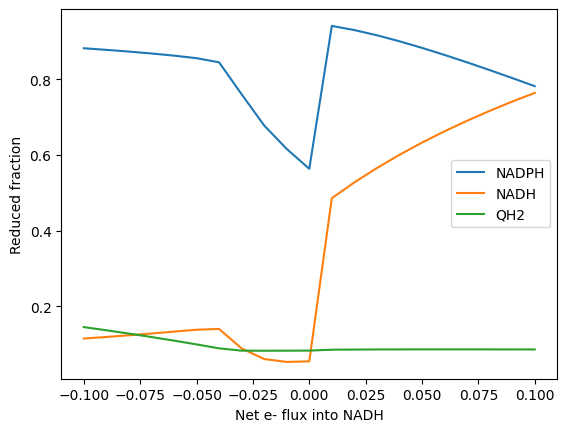

In [16]:
fig, ax = plt.subplots()
for (oxidized, reduced), charges in zip(couples, pool_charge.T):
    ax.plot(rate_range*1000, charges, label=reduced.label)
ax.legend()
ax.set_xlabel("Net e- flux into NADH")
# ax.set_xticks(rate_range, rotation=45)
ax.set_ylabel("Reduced fraction")
plt.show()

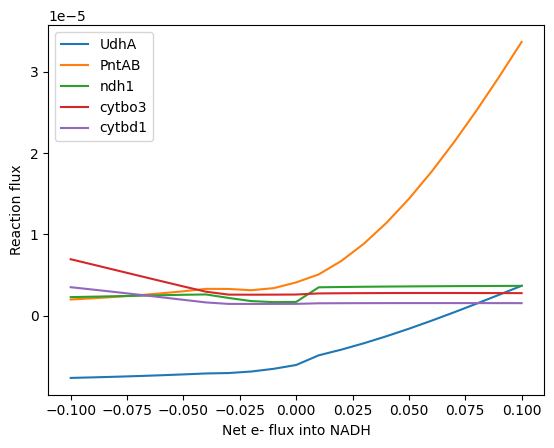

In [17]:
fig, ax = plt.subplots()
for r, v in zip(network.reactions, velocities.T):
    if r not in drivers:
        ax.plot(rate_range*1000, v, label=r.label)
ax.legend()
ax.set_xlabel("Net e- flux into NADH")
ax.set_ylabel("Reaction flux")
plt.show()

Ndh1 is saturated, with very small Vmax. Nothing can get through. Interesting structure, though.

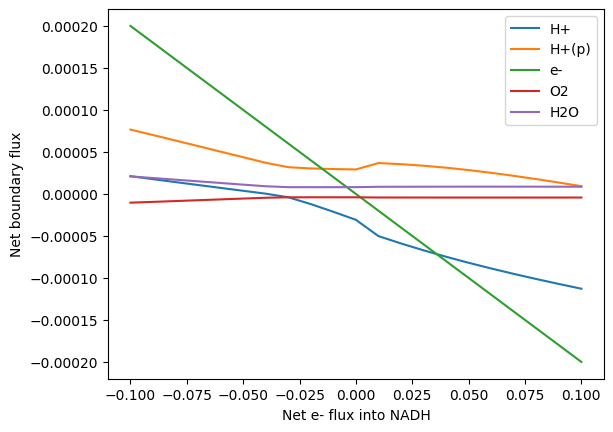

In [18]:
fig, ax = plt.subplots()
for b in boundaries:
    ax.plot(rate_range*1000, dmdts[:, network.reactants.index_of(b)], label=b.label)
ax.legend()
ax.set_xlabel("Net e- flux into NADH")
ax.set_ylabel("Net boundary flux")
plt.show()

- e- flux is consistent (though two electrons per unit of flux throguh reduction half-reaction)
- H+ efflux is highest at most _negative_ flux through nad_reduction, i.e. PMF-coupled transhydrogenase is lowest

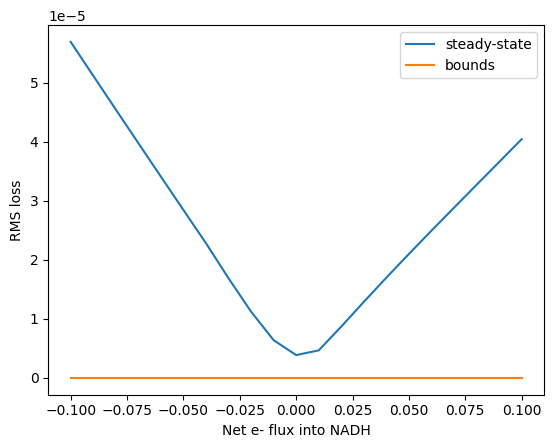

In [19]:
fig, ax = plt.subplots()
ax.plot(rate_range*1000, ss_loss, label="steady-state")
ax.plot(rate_range*1000, bounds_loss, label="bounds")
ax.legend()
ax.set_xlabel("Net e- flux into NADH")
ax.set_ylabel("RMS loss")
plt.show()

Steady-state RMS loss is on par with overall flux numbers, i.e. not steady state at all. So the rest of the results are not really valid anyway.

**Bottom line:** Need much more Ndh1 capacity for any of this to make sense.

In [20]:
data = {}
for rxn in network.reactions:
    if rxn not in drivers:
        data[rxn] = {
            "enz_conc": enzymes[rxn],
            "kcat_f": reaction_kinetics[rxn].kcat_f,
            "kcat_b": reaction_kinetics[rxn].kcat_b,
            "Vmax_f": enzymes[rxn] * reaction_kinetics[rxn].kcat_f,
            "Vmax_b": enzymes[rxn] * reaction_kinetics[rxn].kcat_b,
        }
pd.DataFrame(data).T

,enz_conc,kcat_f,kcat_b,Vmax_f,Vmax_b
[UdhA] NADH + NADP+ <=> NAD+ + NADPH,2.479796e-07,200.000000,6.649484e+01,0.000050,1.648937e-05
[PntAB] NADH + NADP+ + H+(p) <=> NAD+ + NADPH + H+,1.360290e-06,183.230423,4.032658e-02,0.000249,5.485584e-08
[ndh1] NADH + Q + 5 H+ => NAD+ + QH2 + 4 H+(p),2.711047e-07,26.000000,1.130132e-02,0.000007,3.063841e-09
[cytbo3] 2 QH2 + 8 H+ + O2 => 2 Q + 8 H+(p) + 2 H2O,6.843426e-07,300.000000,2.584412e-22,0.000205,1.768623e-28
[cytbd1] 2 QH2 + 4 H+ + O2 => 2 Q + 4 H+(p) + 2 H2O,1.071073e-07,470.000000,2.974949e-36,0.000050,3.186387e-43


- Ndh1 is indeed limiting, with Vmax = 7e-6 mM/s (check units). No way that's enough.
- UdhA is not much better, 5e-5 mM/s. This _could_ be correct under aerobic growth on glucose, where the NADPH => NADH route is not important
- Cytochrome bd1 is as limited as UdhA. This probably _is_ correct, as it is down-regulated in high O2

Gotta check either the kinetics or the enzyme levels for Ndh1

### Try with Ndh1 kcats aribtrarily 100x higher

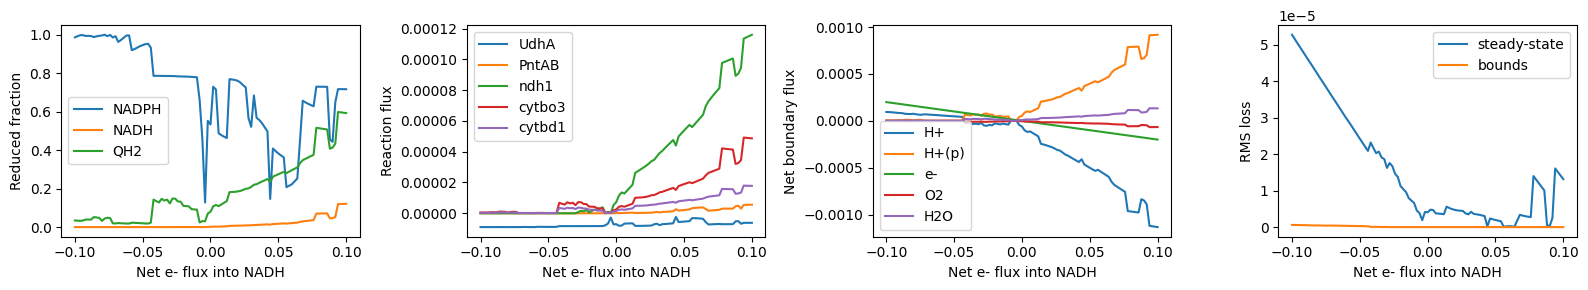

In [21]:
_kinetics = {k: v for k, v in reaction_kinetics.items()}
_kinetics[ndh1] = ReactionKinetics.thermo_consistent(
    reaction=ndh1, delta_g=thermo.reaction_delta_g(ndh1), km={nadh: 0.013, qone: 0.08}, kcat_f=2600., ignore=ignore)
_equations = ConvenienceKinetics(network, _kinetics, ignore=ignore)

def _network_rates(state, enz_state, driver_rates):
    rates = _equations.reaction_rates(state, enz_state)
    rates = rates.at[drivers_i].add(driver_rates)
    return rates

def _residual(x, driver_rates):
    rates = _network_rates(adjusted_state(state0, x), enz_state, driver_rates)
    dmdt = network.s_matrix @ rates
    return jnp.concatenate([jnp.maximum(0, -x) + jnp.maximum(0, x - 1), dmdt[intermediates_i]])

rate_range = np.linspace(-1e-4, 1e-4, 101)
_pool_charge = []
for rate in rate_range:
    soln = scipy.optimize.least_squares(
        fun=jax.jit(_residual),
        jac=jax.jit(jax.jacfwd(_residual)),
        x0 = jnp.ones(3) * 0.5,
        args=((rate * driver_mask,)),
    )
    _pool_charge.append(soln.x)

_pool_charge = np.array(_pool_charge)
_states = np.array([adjusted_state(state0, x) for x in _pool_charge])
_velocities = np.array([_network_rates(state, enz_state, rate * driver_mask) for state, rate in zip(_states, rate_range)])
_dmdts = _velocities @ network.s_matrix.T
_ss_loss = np.sqrt(np.mean(np.square(_dmdts[:, intermediates_i]), axis=-1))
_bounds_loss = np.sqrt(np.mean(np.square(np.maximum(0, -_pool_charge) + np.maximum(0, _pool_charge - 1)), axis=-1))

fig, ax = plt.subplots(1, 4, figsize=(16, 3))

for (oxidized, reduced), charges in zip(couples, _pool_charge.T):
    ax[0].plot(rate_range*1000, charges, label=reduced.label)
ax[0].legend()
ax[0].set_xlabel("Net e- flux into NADH")
ax[0].set_ylabel("Reduced fraction")

for r, v in zip(network.reactions, _velocities.T):
    if r not in drivers:
        ax[1].plot(rate_range*1000, v, label=r.label)
ax[1].legend()
ax[1].set_xlabel("Net e- flux into NADH")
ax[1].set_ylabel("Reaction flux")

for b in boundaries:
    ax[2].plot(rate_range*1000, _dmdts[:, network.reactants.index_of(b)], label=b.label)
ax[2].legend()
ax[2].set_xlabel("Net e- flux into NADH")
ax[2].set_ylabel("Net boundary flux")

ax[3].plot(rate_range*1000, _ss_loss, label="steady-state")
ax[3].plot(rate_range*1000, _bounds_loss, label="bounds")
ax[3].legend()
ax[3].set_xlabel("Net e- flux into NADH")
ax[3].set_ylabel("RMS loss")

plt.tight_layout()
plt.show()

Much more what we expect
- QH2 reduced fraction, reaction rates, H+ efflux, all proportional to positive e- flux into NADH
- Can't run backward, at least not in this configuration
  - No real flux except for UdhA
  - steady-state error increases rapidly
- Not particularly smooth, some instability somewhere